In [1]:
import tensorflow as tf 
from tensorflow import keras
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd 
%matplotlib inline

from tensorflow.keras.layers import Dropout, Flatten, Dense, Input
from tensorflow.keras.models import Sequential, model_from_json
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions



In [2]:
base_model = VGG16(weights='imagenet', include_top = False, 
                   input_tensor=Input(shape=(224, 224, 3)))

batch_size = 32
nrow = 224
ncol = 224
nchan = 3

batch_shape = (batch_size, nrow, ncol, nchan)
x = np.zeros(batch_shape)

base_model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
bloc

In [3]:
model = Sequential()
for i in base_model.layers:
    model.add(i)
for i in model.layers:
    i.trainable = False
    
model.add(Flatten(input_shape = (224, 224, 3)))
model.add(Dense(256, activation = 'relu'))
model.add(Dropout(0.25))
model.add(Dense(256, activation = 'relu'))
model.add(Dropout(0.25))
model.add(Dense(24, activation = 'softmax'))

model.summary()

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
___________________________

In [4]:
train_data_dir = './Dataset'
batch_size = 32
train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)
train_generator = train_datagen.flow_from_directory(
                        train_data_dir,
                        target_size=(nrow,ncol),
                        batch_size=batch_size,
                        class_mode='categorical')

test_data_dir = './Val'
batch_size = 32
test_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)
test_generator = test_datagen.flow_from_directory(
                        test_data_dir,
                        target_size=(nrow,ncol),
                        batch_size=batch_size,
                        class_mode='categorical')


Found 27455 images belonging to 24 classes.
Found 7172 images belonging to 24 classes.


In [5]:
def disp_image(im):
    if (len(im.shape) == 2):
        # Gray scale image
        plt.imshow(im, cmap='gray',origin="lower")    
    else:
        # Color image.  
        im1 = (im-np.min(im))/(np.max(im)-np.min(im))*255
        im1 = im1.astype(np.uint8)
        plt.imshow(im1)    
        
    # Remove axis ticks
    plt.xticks([])
    plt.yticks([])

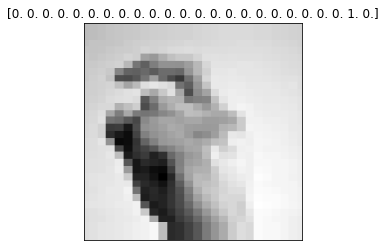

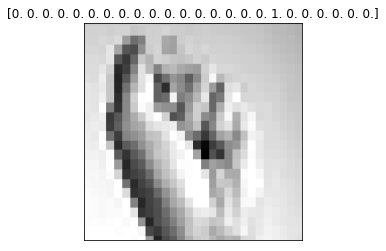

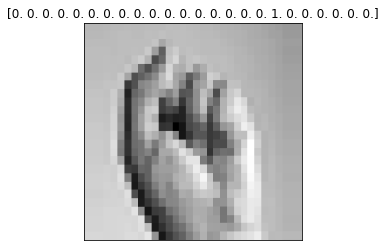

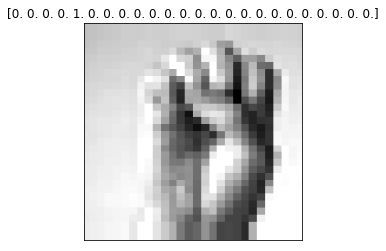

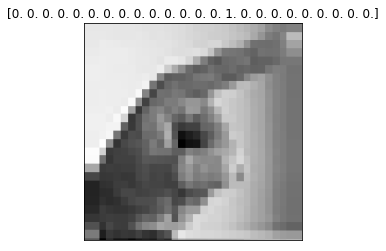

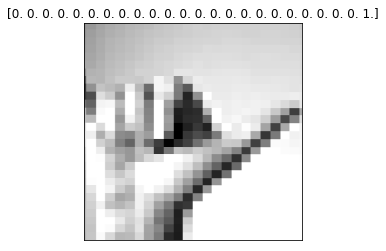

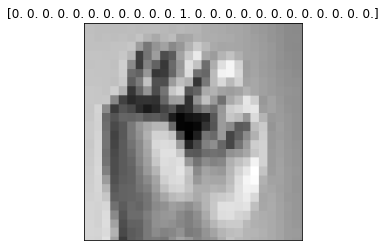

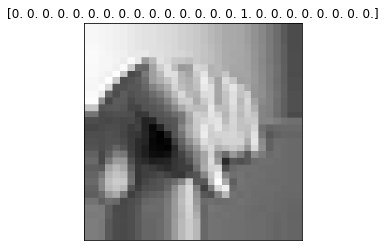

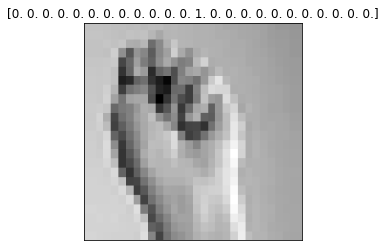

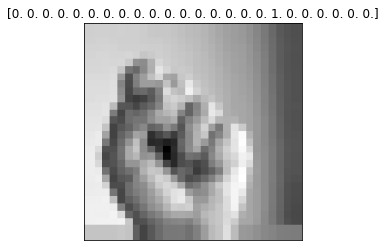

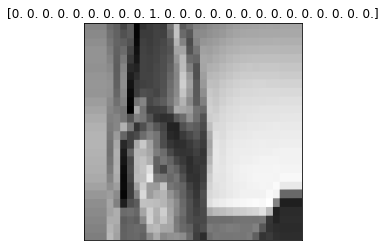

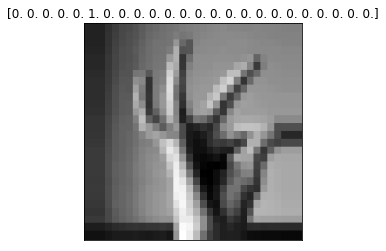

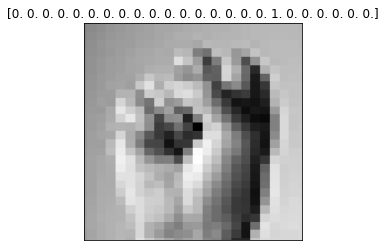

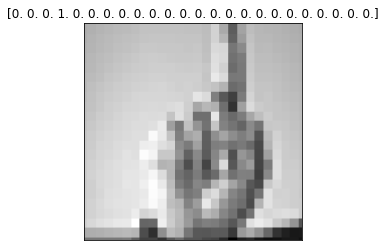

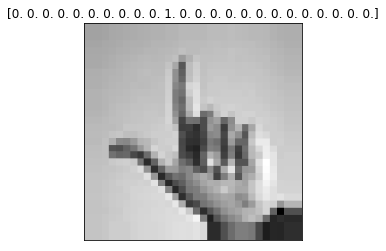

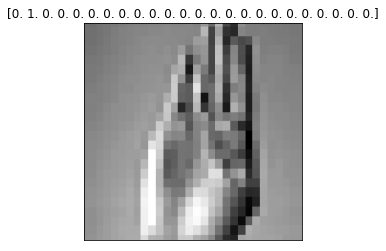

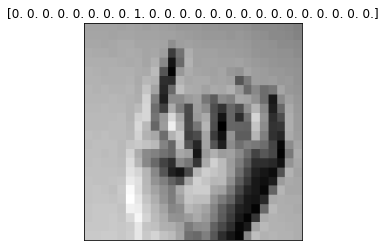

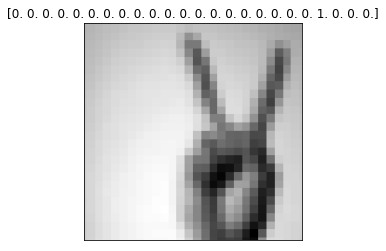

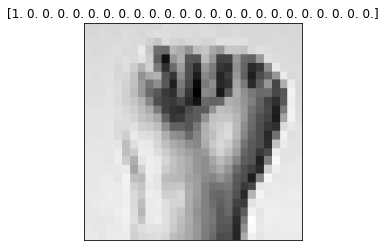

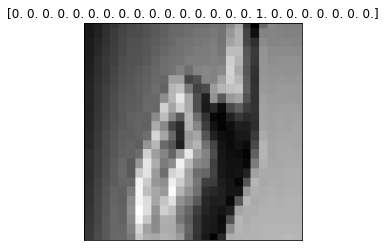

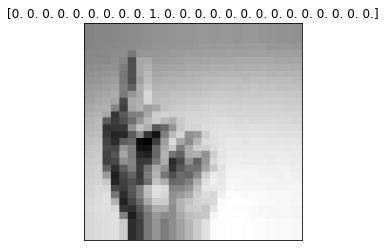

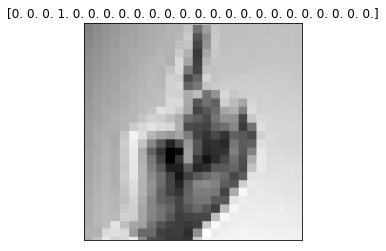

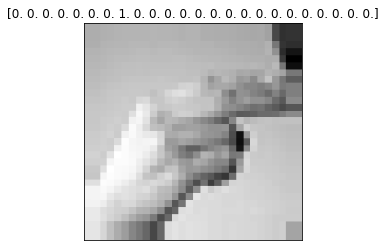

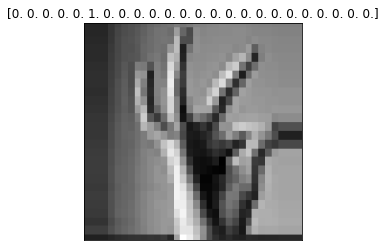

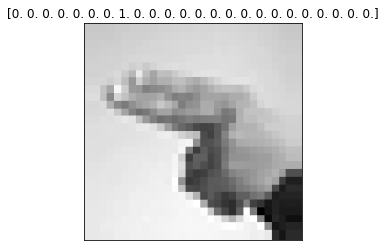

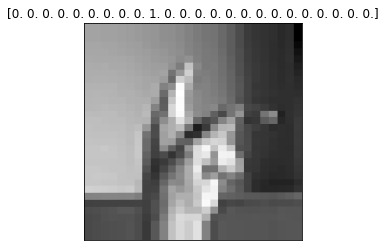

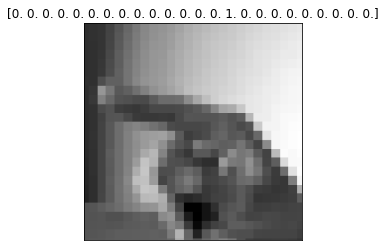

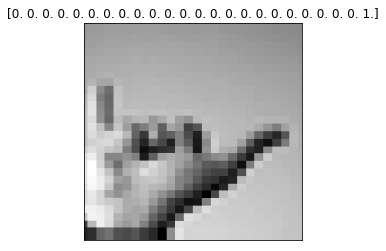

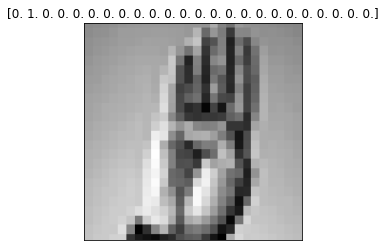

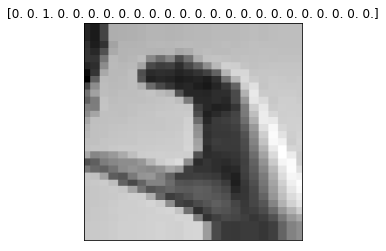

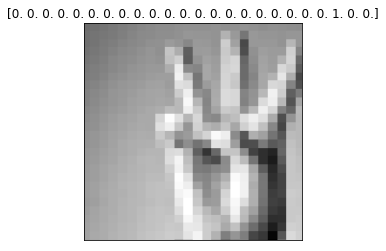

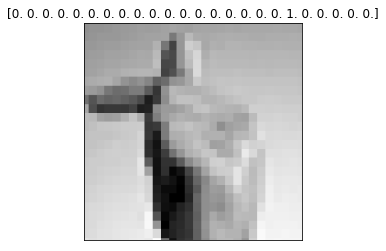

In [6]:
X,y = train_generator.next()
for i in range (len(X)):
    disp_image(X[i])
    plt.title(y[i])
    plt.show()

In [ ]:
model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])
#categorical_crossentropy
steps_per_epoch =  train_generator.n // batch_size
validation_steps =  test_generator.n // batch_size

In [ ]:
nepochs = 10

hist = model.fit_generator(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=nepochs,
    validation_data=test_generator,
    validation_steps=validation_steps)

Instructions for updating:
Use tf.cast instead.
Epoch 1/10
190/225 [========================>.....] - ETA: 24s - loss: 2.9724 - acc: 0.0850    

In [ ]:
#Model to JSON
model_json = model.to_json()
with open("model.json", "w") as f:
    f.write(model_json)
#Weights to HDF5
model.save_weights("weights.h5")
print("Saved model to disk")

In [ ]:
with open('model.json','r') as f:
    json = f.read()
loaded_model = model_from_json(json)
loaded_model.load_weights("weights.h5", by_name=True)

 
# evaluate loaded model on test data
loaded_model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])

Xtest,ytest = test_generator.next()
yhat = loaded_model.predict(Xtest)
l = len(Xtest)
for i in range (l):
    disp_image(Xtest[i])
    plt.title("Actual: "+str(ytest[i])+" Predicted: " + str(yhat[i]))
    plt.show()